# Configuration Code

In [11]:

import os
workingDir = '.\\'
os.chdir(workingDir)

conf_file = '.\\para-adult.yaml'
Sample_Size = 10000

export_dir = '.\\tmp\\'

import pandas as pd
import numpy as np
import os
#os.chdir(workingDir)
import collections
import matplotlib
import io
import sys
import operator

import nbformat as nbf
from IPython.core.display import HTML
from IPython.display import display
from ipywidgets import interact, interactive,fixed
from IPython.display import Javascript, display,HTML
from ipywidgets import widgets, VBox
import ipywidgets
import IPython
from IPython.display import clear_output
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
import errno
import seaborn as sns
from string import Template
from functools import partial
from collections import OrderedDict

# Utility Classes
from ConfUtility import * 
from ReportGeneration import *
from UniVarAnalytics import *
from MultiVarAnalytics import *

%matplotlib inline

#DEBUG=0

font={'family':'normal','weight':'normal','size':8}
matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12.0, 5.0)
matplotlib.rc('xtick', labelsize=9) 
matplotlib.rc('ytick', labelsize=9)
matplotlib.rc('axes', labelsize=10)
matplotlib.rc('axes', titlesize=10)
sns.set_style('whitegrid')

if not os.path.exists(export_dir):
    os.makedirs(export_dir)
    
def gen_report(conf_md,conf_code, md, code, filename):
    ReportGeneration.write_report(conf_md, conf_code, md, code, report_name=filename)

def translate_code_commands(cell, exported_cols, composite=False):    
    new_code_store = []
    exported_cols = [each for each in exported_cols if each!='']   
    for each in exported_cols:       
        w,x,y = each.split(',')
        with open('log.txt','w') as fout:
            fout.write('Processing call for the column {}'.format(each))
        temp=cell[0]

        new_line = temp.replace('interactive','apply').replace(
            "df=fixed(df)","df").replace("filename=fixed(filename)","'"+ReportMagic.var_files+"'").replace(
            "col1=w1","'"+w+"'").replace("col2=w2","'"+x+"'").replace("col3=w3","'"+y+"'").replace(
            "col3=fixed(w3)","'"+y+"'").replace(
            "Export=w_export","False").replace("conf_dict=fixed(conf_dict)","conf_dict")       
        new_line = new_line.replace("df,","[df,")
        new_line = new_line[:len(new_line)-1]+"])"
        new_line = new_line.replace("apply(","").replace(", [", "(*[")
        new_code_store.append(new_line)        
    return new_code_store

def add_to_report(section='', task=''):
    print ('Section {}, Task {} added for report generation'.format(section ,task))

def trigger_report(widgets,export_cols_file, output_report, no_widgets=1, md_text=''):
    exported_cols = []
    with open(export_cols_file,'r') as fin:
        for each in fin:
            each = each.strip()
            if each and not each.isspace():
                exported_cols.append(each)
                
    exported_cols = list(set(exported_cols))
    conf_md, conf_code, md, code=%show_report 
    md = md_text
    cell = code
    new_code_store = translate_code_commands(cell,exported_cols)
    gen_report(conf_md,conf_code, md, new_code_store, filename=export_dir+output_report)
    
def silentremove(filename):
    try:
        os.remove(filename)
    except OSError as e: # this would be "except OSError, e:" before Python 2.6
        if e.errno != errno.ENOENT: # errno.ENOENT = no such file or directory
            raise # re-raise exception if a different error occured

def handle_change(value):
    w_export.value=False

def getWidgetValue(w):
    w_value = ''
    try:
        w_value = w.value
    except:
        pass    
    return w_value

def handle_export(widget, w1, w2, w3, export_filename='temp.ipynb',md_text=''):    
    print ('Export is successful!')
    w1_value, w2_value, w3_value = \
        getWidgetValue(w1),getWidgetValue(w2),getWidgetValue(w3)
    st = ','.join(str(each) for each in [w1_value, w2_value, w3_value])
    with open(filename,'a') as fout:
        fout.write(st+'\n')
    trigger_report(w1_value, filename, export_filename, False, md_text=md_text)  
    
            

conf_dict = ConfUtility.parse_yaml(conf_file)

# Read in data from local file or SQL server
if 'DataSource' not in conf_dict:
    df=pd.read_csv(conf_dict['DataFilePath'][0], skipinitialspace=True)
else:
    import pyodbc
    cnxn = pyodbc.connect('driver=ODBC Driver 11 for SQL Server;server={};database={};Uid={};Pwd={}'.format(
            conf_dict['Server'], conf_dict['Database'],conf_dict['Username'],conf_dict['Password']))
    df = pd.read_sql(conf_dict['Query'],cnxn)

# Making sure that we are not reading any extra column
df = df[[each for each in df.columns if 'Unnamed' not in each]]

# Sampling Data if data size is larger than 10k
df0 = df # df0 is the unsampled data. Will be used in data exploration and analysis where sampling is not needed
         # However, keep in mind that your final report will always be based on the sampled data. 
if Sample_Size < df.shape[0]:
    df = df.sample(Sample_Size)

# change float data types
if 'FloatDataTypes' in conf_dict:   
    for col_name in conf_dict['FloatDataTypes']:
        df[col_name] = df[col_name].astype(float)      
        
# Getting the list of categorical columns if it was not there in the yaml file
if 'CategoricalColumns' not in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(list(df.select_dtypes(exclude=[np.number]).columns)))

# Getting the list of numerical columns if it was not there in the yaml file
if 'NumericalColumns' not in conf_dict:
    conf_dict['NumericalColumns'] = list(df.select_dtypes(include=[np.number]).columns)    

# Exclude columns that we do not need
if 'ColumnsToExclude' in conf_dict:
    conf_dict['CategoricalColumns'] = list(set(conf_dict['CategoricalColumns'])-set(conf_dict['ColumnsToExclude']))
    conf_dict['NumericalColumns'] = list(set(conf_dict['NumericalColumns'])-set(conf_dict['ColumnsToExclude']))

# Ordering the categorical variables according to the number of unique categories
filtered_cat_columns = []
temp_dict = {}
for cat_var in conf_dict['CategoricalColumns']:
    temp_dict[cat_var] = len(np.unique(df[cat_var]))
sorted_x = sorted(temp_dict.items(), key=operator.itemgetter(0), reverse=True)
conf_dict['CategoricalColumns'] = [x for (x,y) in sorted_x]

ConfUtility.dict_to_htmllist(conf_dict,['Target','CategoricalColumns','NumericalColumns'])
def custom_head(df,NoOfRows):
    return HTML(df.head(NoOfRows).style.set_table_attributes("class='table'").render())
i = interact(custom_head,df=fixed(df0), NoOfRows=ipywidgets.IntSlider(min=0, max=30, step=1, \
                                                                     value=5, description='Number of Rows'))
print ('The data has {} Rows and {} columns'.format(df0.shape[0],df0.shape[1]))
col_names = ','.join(each for each in list(df.columns))
print("The column names are:" + col_names)
print("The types of columns are:")
df.dtypes
def num_missing(x):
    return len(x.index)-x.count()

def num_unique(x):
    return len(np.unique(x))

temp_df = df0.describe().T
missing_df = pd.DataFrame(df0.apply(num_missing, axis=0)) 
missing_df.columns = ['missing']
unq_df = pd.DataFrame(df0.apply(num_unique, axis=0))
unq_df.columns = ['unique']
types_df = pd.DataFrame(df0.dtypes)
types_df.columns = ['DataType']
summary_df = temp_df.join(missing_df).join(unq_df).join(types_df)
summary_df
col_names = list(types_df.index) #Get all col names
num_cols = len(col_names)
index = range(num_cols)
cat_index = []
for i in index: #Find the indices of columns in Categorical columns
    if col_names[i] in conf_dict['CategoricalColumns']:
        cat_index.append(i)
summary_df_cat = missing_df.join(unq_df).join(types_df.iloc[cat_index], how='inner') #Only summarize categorical columns
summary_df_cat

The data has 32561 Rows and 15 columns
The column names are:age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
The types of columns are:


,missing,unique,DataType
workclass,0,9,object
education,0,16,object
marital_status,0,7,object
occupation,0,15,object
relationship,0,6,object
race,0,5,object
sex,0,2,object
native_country,0,42,object
income,0,2,int64


## Project Data to 3-D Principal Component Space (on sampled data)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


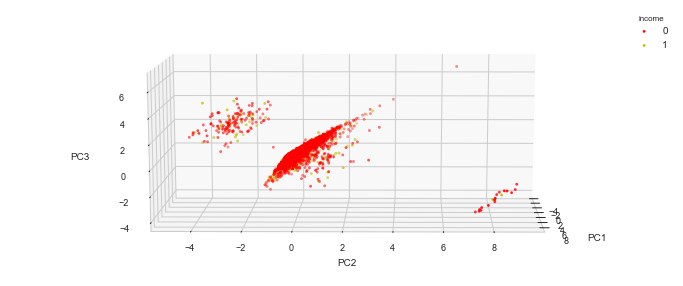

In [13]:

i = InteractionAnalytics.pca_3d(*[df, conf_dict,                                              'income', '1', '2',False])

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


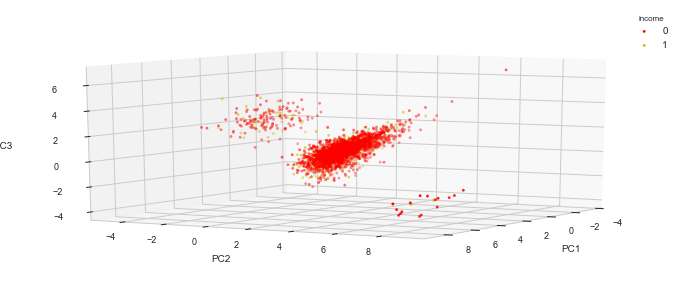

In [14]:

i = InteractionAnalytics.pca_3d(*[df, conf_dict,                                              'income', '30', '',False])